In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - linear_model_prior.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Determine the best-fitting linear model with the addition of a prior. Compare to 
data from other sources
'''

__author__ = "James Lane"

In [8]:
# General
import numpy as np
import pdb, sys, importlib, copy
from tqdm import tqdm_notebook

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits
from astropy.table import Table

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit
from scipy import linalg
import scipy as sc

## Galpy
from galpy import potential

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.util
import ast1501.fourier
import ast1501.df
import ast1501.linear_model

In [9]:
### Matplotlib for notebooks
%config InlineBackend.figure_format = 'retina'

# Meta

## Information:
- paper: https://arxiv.org/abs/1008.4686

## Future Work:
- Make sure that all work in the notebook is done using a single set of bootstraps

# About

We assume that the velocity fluctuations induced by the triaxial halo obeys the following restrictions:
- Only produces power in an m=2 mode
- Phase is constant with radius
- Smooth radial trend in power that tends to increase

Fit a simple linear model:

$
v_{T}(R,\phi) = v_{T,0}(R) + A_{T}(R) \cos \big[ 2( \phi - \phi_{b} ) \big] + N_{T}(R)
$

$
v_{R}(R,\phi) =  A_{R}(R) \sin \big[ 2( \phi - \phi_{b} ) \big] + N_{R}(R)
$

See notebook marginalize_linear_fit.ipynb or section below for more information about the linear algebra solution to this problem

Also now add a Gaussian prior on the system. 

$
\exp \big[ ( {\bf X} - {\bf X}_{0} )^{T} {\bf \Sigma}^{-1} ( {\bf X} - {\bf X}_{0} ) \big]
$

Here, ${\bf X}_{0}$ is the column vector prior for each parameter in the linear fit. ${\bf \Sigma}$ is the standard deviation of the Gaussian prior. For a uniform prior, the width of the prior approaches infinity. Therefore this can be accomplished by setting the element in the inverse variance matrix equal to 0.

- Determine a fixed $\phi_{b}$, subject to a prior.
- Calculate $m=2$ amplitudes as a function radius, subject to a prior.
- Compare $m=2$ amplitudes with models

# Prepare

## Load Data

In [10]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = np.sin(gc_phi)*gc_vx - np.cos(gc_phi)*gc_vy
gc_phi = np.arctan2(gc_y,-gc_x)

# R: 5-15 kpc

## Set Parameters

In [67]:
# Radial bin range and size
R_lims = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lims = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lims[0], phi_lims[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/30
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2

## Generate Bootstrap Sample

In [68]:
make_new_bs_sample = True
if not make_new_bs_sample:
    sys.exit('Not making a new bootstrap sample!')
##fi

n_bs = 100
bs_samples_vR, bs_samples_vT = ast1501.linear_model.make_bootstrap_samples(gc_R, gc_phi, 
    gc_vR, gc_vT, R_bin_cents, R_bin_size, phi_bin_cents, phi_bin_size, n_bs)

## Evaluate

In [69]:
importlib.reload(ast1501.linear_model)

n_iterate = 5
var_arr = [25,np.inf,25,np.inf] # variance for b vT, m vT, b vR, m vR
force_yint_zero_vR = False

results = ast1501.linear_model.run_iterating_linear_model(R_bin_cents, R_bin_size, 
                                                          phib_bin_cents, bs_samples_vT, 
                                                          bs_samples_vR, var_arr, 
                                                          force_yint_zero_vR, n_iterate)

# Unpack interesting things
_, _, _, _, _, phib_all, bs_all, ms_all, bs_err_all, ms_err_all, _ = results[-1]
R_bin_cents_all = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

In [81]:
ms_all[:,0]

array([14.53358646, 23.16017484, 13.30835298, 23.4455608 , 24.61324511,
       25.92212409, 27.97215173, 34.06650671, 31.36980031, 30.48164087])

# R 10-15 kpc

## Set Parameters

In [14]:
# Radial bin range and size
R_lims = [10,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lims = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lims[0], phi_lims[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/30
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2

## Generate Bootstrap Sample

In [15]:
make_new_bs_sample = True
if not make_new_bs_sample:
    sys.exit('Not making a new bootstrap sample!')
##fi

n_bs = 100
bs_samples_vR, bs_samples_vT = ast1501.linear_model.make_bootstrap_samples(gc_R, gc_phi, 
    gc_vR, gc_vT, R_bin_cents, R_bin_size, phi_bin_cents, phi_bin_size, n_bs)

## Evaluate

In [16]:
importlib.reload(ast1501.linear_model)

n_iterate = 5
var_arr = [25,np.inf,25,np.inf] # variance for b vT, m vT, b vR, m vR
force_yint_zero_vR = False

results = ast1501.linear_model.run_iterating_linear_model(R_bin_cents, R_bin_size, 
                                                          phib_bin_cents, bs_samples_vT, 
                                                          bs_samples_vR, var_arr, 
                                                          force_yint_zero_vR, n_iterate)

# Unpack interesting things
_, _, _, _, _, phib_od, bs_od, ms_od, bs_err_od, ms_err_od, _ = results[-1]
R_bin_cents_od = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

# R 5-10 kpc

## Set Parameters

In [17]:
# Radial bin range and size
R_lims = [5,10]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lims = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lims[0], phi_lims[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/30
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2

## Generate Bootstrap Sample

In [18]:
make_new_bs_sample = True
if not make_new_bs_sample:
    sys.exit('Not making a new bootstrap sample!')
##fi

n_bs = 100
bs_samples_vR, bs_samples_vT = ast1501.linear_model.make_bootstrap_samples(gc_R, gc_phi, 
    gc_vR, gc_vT, R_bin_cents, R_bin_size, phi_bin_cents, phi_bin_size, n_bs)

## Evaluate

In [19]:
importlib.reload(ast1501.linear_model)

n_iterate = 5
var_arr = [25,np.inf,25,np.inf] # variance for b vT, m vT, b vR, m vR
force_yint_zero_vR = False

results = ast1501.linear_model.run_iterating_linear_model(R_bin_cents, R_bin_size, 
                                                          phib_bin_cents, bs_samples_vT, 
                                                          bs_samples_vR, var_arr, 
                                                          force_yint_zero_vR, n_iterate)
    
# Unpack interesting things
_, _, _, _, _, phib_id, bs_id, ms_id, bs_err_id, ms_err_id, _ = results[-1]
R_bin_cents_id = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

## Compare the two slices to each other and the total sample

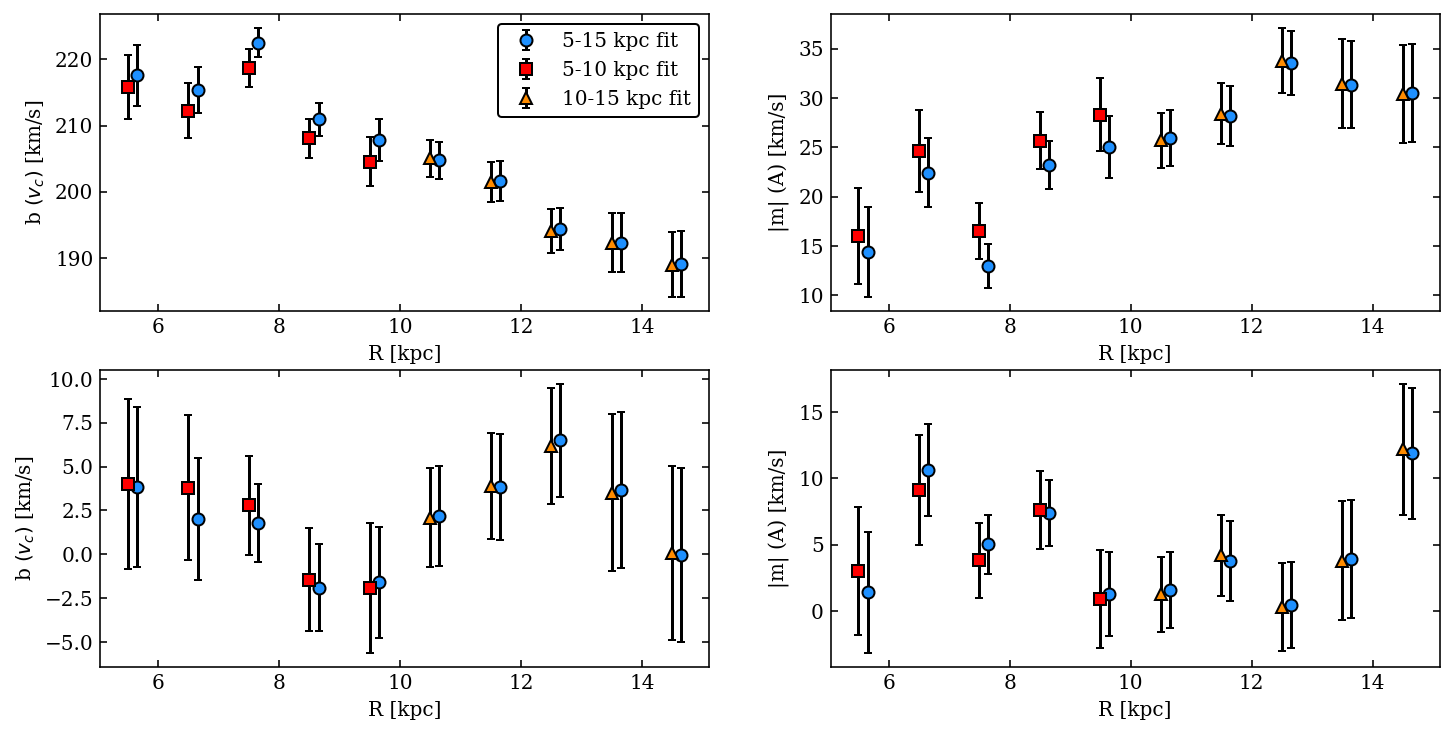

In [20]:
fig = plt.figure( figsize=(12,6) ) 
axs = fig.subplots( nrows=2, ncols=2 )

axs[0,0].errorbar(R_bin_cents_all+0.15, bs_all[:,0], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_all[:,0], ecolor='Black', 
                  capsize=2, marker='o', label='5-15 kpc fit')
axs[0,0].errorbar(R_bin_cents_id, bs_id[:,0], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='Red', yerr=bs_err_id[:,0], ecolor='Black', 
                  capsize=2, marker='s', label='5-10 kpc fit')
axs[0,0].errorbar(R_bin_cents_od, bs_od[:,0], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DarkOrange', yerr=bs_err_od[:,0], ecolor='Black', 
                  capsize=2, marker='^', label='10-15 kpc fit')

axs[0,1].errorbar(R_bin_cents_all+0.15, np.abs(ms_all[:,0]), fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_all[:,0], ecolor='Black', 
                  capsize=2, marker='o')
axs[0,1].errorbar(R_bin_cents_id, np.abs(ms_id[:,0]), fmt='o', markeredgecolor='Black', 
                  markerfacecolor='Red', yerr=bs_err_id[:,0], ecolor='Black', 
                  capsize=2, marker='s')
axs[0,1].errorbar(R_bin_cents_od, np.abs(ms_od[:,0]), fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DarkOrange', yerr=bs_err_od[:,0], ecolor='Black', 
                  capsize=2, marker='^')

axs[1,0].errorbar(R_bin_cents_all+0.15, bs_all[:,1], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_all[:,0], ecolor='Black', 
                  capsize=2, marker='o')
axs[1,0].errorbar(R_bin_cents_id, bs_id[:,1], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='Red', yerr=bs_err_id[:,0], ecolor='Black', 
                  capsize=2, marker='s')
axs[1,0].errorbar(R_bin_cents_od, bs_od[:,1], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DarkOrange', yerr=bs_err_od[:,0], ecolor='Black', 
                  capsize=2, marker='^')

axs[1,1].errorbar(R_bin_cents_all+0.15, np.abs(ms_all[:,1]), fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_all[:,0], ecolor='Black', 
                  capsize=2, marker='o')
axs[1,1].errorbar(R_bin_cents_id, np.abs(ms_id[:,1]), fmt='o', markeredgecolor='Black', 
                  markerfacecolor='Red', yerr=bs_err_id[:,0], ecolor='Black', 
                  capsize=2, marker='s')
axs[1,1].errorbar(R_bin_cents_od, np.abs(ms_od[:,1]), fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DarkOrange', yerr=bs_err_od[:,0], ecolor='Black', 
                  capsize=2, marker='^')

axs[0,0].set_xlabel('R [kpc]')
axs[0,0].set_ylabel(r'b $(v_{c})$ [km/s]')
axs[0,1].set_xlabel('R [kpc]')
axs[0,1].set_ylabel(r'|m| (A) [km/s]')
axs[1,1].set_xlabel('R [kpc]')
axs[1,1].set_ylabel(r'|m| (A) [km/s]')
axs[1,0].set_xlabel('R [kpc]')
axs[1,0].set_ylabel(r'b $(v_{c})$ [km/s]')

axs[0,0].legend()

fig.savefig('separate_radius_fits')
plt.show()
plt.clf()
plt.close('all')

pass;

# Examine what happens with DF data

## Set Parameters

In [21]:
# Phib bin range and size
phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/45
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2

# Other
n_iterate = 3
var_arr = [25,np.inf,25,np.inf] # variance for b vT, m vT, b vR, m vR
force_yint_zero_vR = False

## Get the perturbation data

In [22]:
pert_file_base = '../../scripts/generate_bar_spiral_triaxial_df/2019-04-21/data_'
pert_file_specs = ['b090.npy','b095.npy']
pert_files = [ pert_file_base+spec for spec in pert_file_specs ]

trihalo_file_base = '../8-radial_DF_generation/data/results_b'
trihalo_file_specs = ['90.npy','95.npy']
trihalo_files = [ trihalo_file_base+spec for spec in trihalo_file_specs ]

assert len(pert_files) == len(trihalo_files)
b_values = [0.9,0.95]
n_files = len(pert_files)

# Spiral arm and bar only data
spiral_file = '../../scripts/generate_spiral_df/base/data.npy'
bar_file = '../../scripts/generate_bar_df/2019-04-24/data.npy'

## b=0.9 and 0.95

../../src/ast1501/linear_model.py:615: RuntimeWarning: divide by zero encountered in log
  store_likelihood_vT[j,:] = np.log(likelihood_vT)

../../src/ast1501/linear_model.py:622: RuntimeWarning: divide by zero encountered in log
  store_likelihood_vR[j,:] = np.log(likelihood_vR)



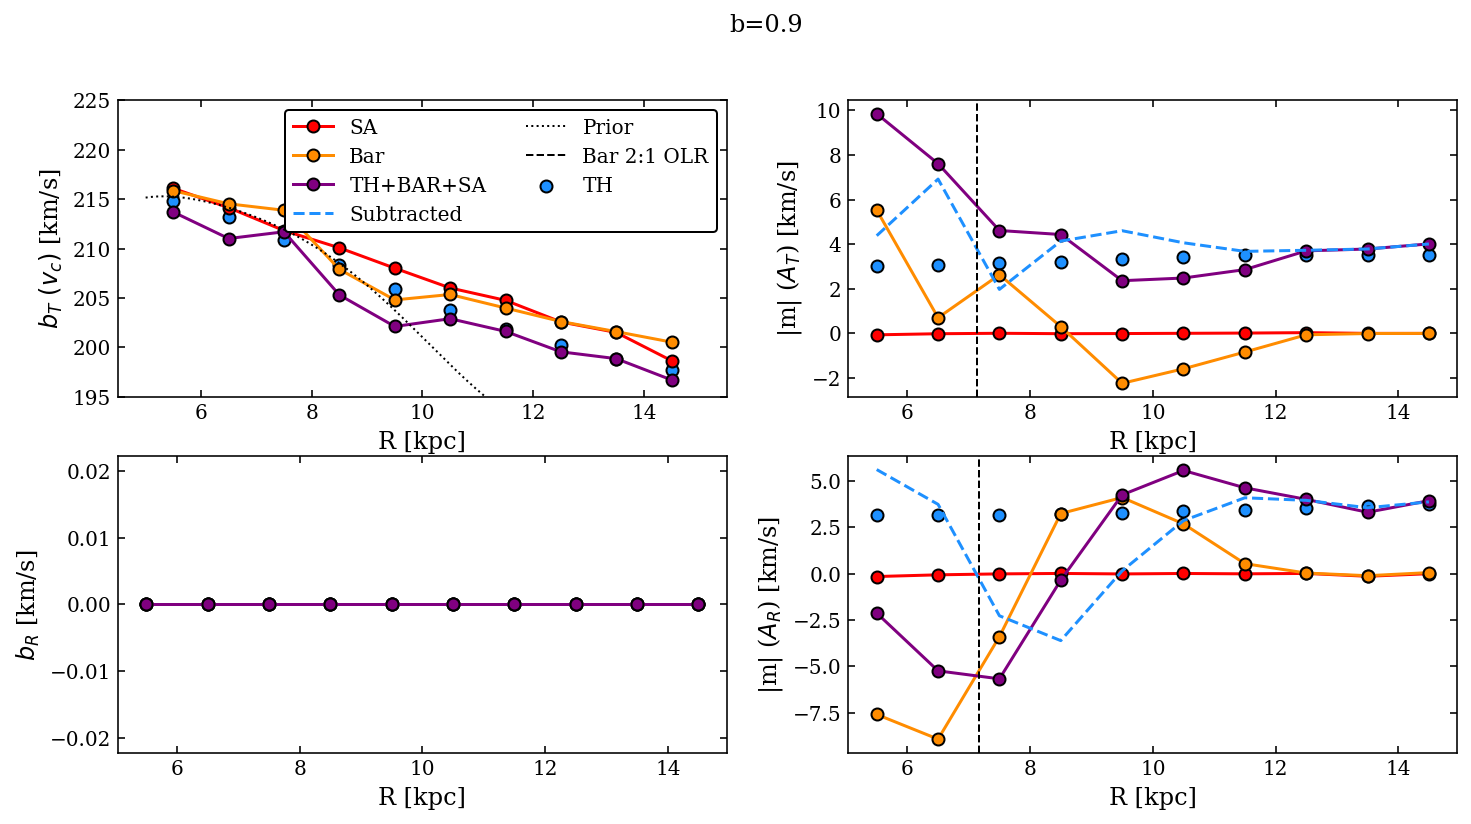

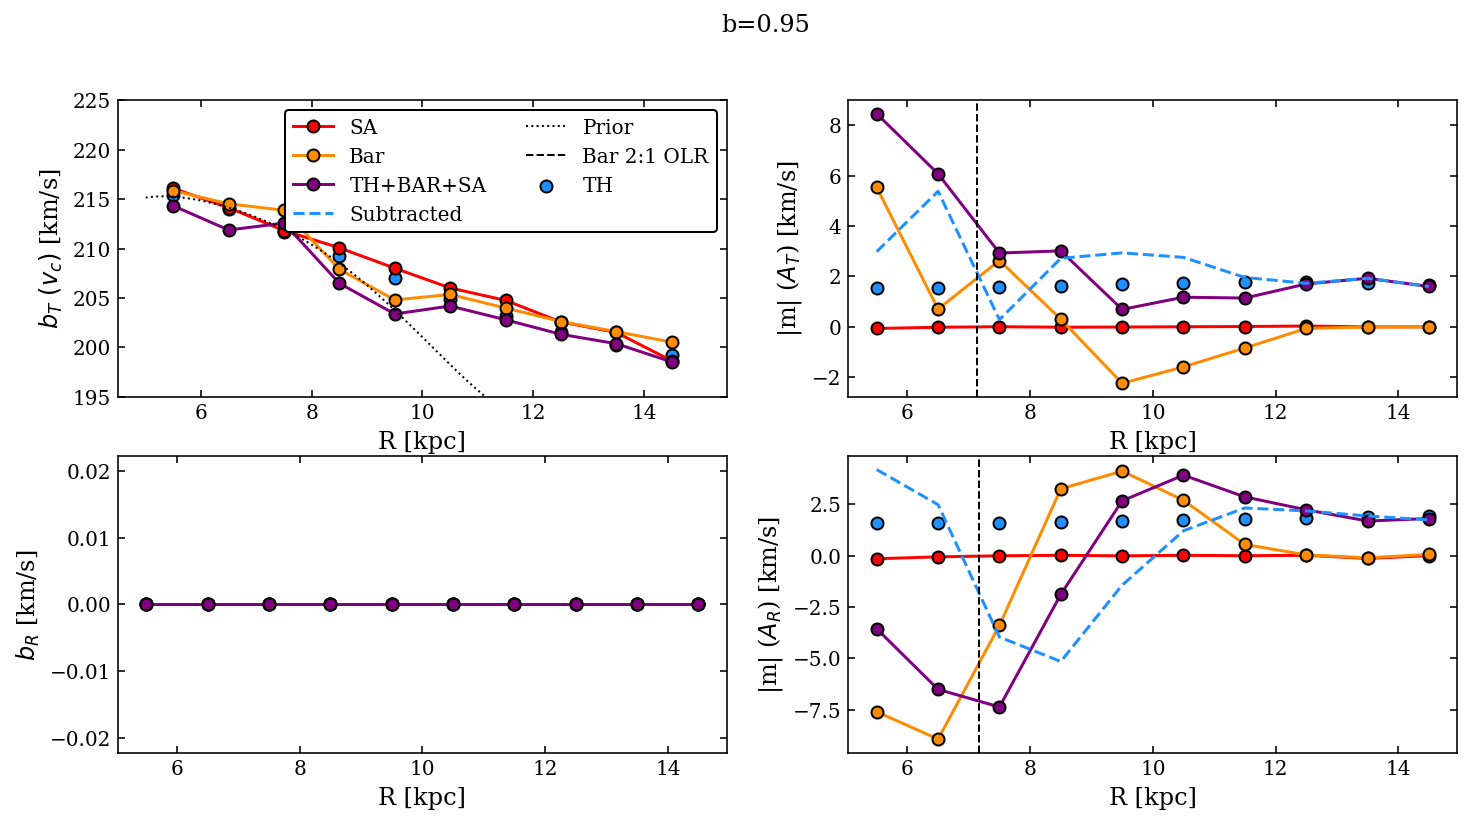

In [66]:
importlib.reload(ast1501.linear_model)

suptitles=['b=0.9','b=0.95']

for i in range(2):
    fig = plt.figure( figsize=(12,6) ) 
    axs = fig.subplots( nrows=2, ncols=2 )

    plot_colors = ['DodgerBlue','Red','DarkOrange','Purple']
    plot_files = [trihalo_files[i],spiral_file,bar_file,pert_files[i]]
    plot_labels = ['TH','SA','Bar','TH+BAR+SA']

    ## Do the triaxial halo
    this_ind = 0
    R_bin_cents, results = ast1501.linear_model.fit_linear_model_df_data(plot_files[this_ind], phib_bin_cents, var_arr, 
                                                            force_yint_zero_vR, n_iterate, force_phiB=0)
    _, _, _, _, _, phib, bs, ms, _, _, _ = results[-1]

    axs[0,0].scatter(R_bin_cents, bs[:,0], edgecolor='Black',
                      facecolor=plot_colors[this_ind], marker='o', label=plot_labels[this_ind])
    axs[0,1].scatter(R_bin_cents, ms[:,0], edgecolor='Black',
                      facecolor=plot_colors[this_ind], marker='o')
    axs[1,0].scatter(R_bin_cents, bs[:,1], edgecolor='Black',
                      facecolor=plot_colors[this_ind], marker='o')
    axs[1,1].scatter(R_bin_cents, ms[:,1], edgecolor='Black',
                      facecolor=plot_colors[this_ind], marker='o')
    bs_th = copy.deepcopy(bs)
    ms_th = copy.deepcopy(ms)

    ## Do the spiral arms
    this_ind = 1
    R_bin_cents, results = ast1501.linear_model.fit_linear_model_df_data(plot_files[this_ind], phib_bin_cents, var_arr, 
                                                            force_yint_zero_vR, n_iterate, force_phiB=0)
    _, _, _, _, _, phib, bs, ms, _, _, _ = results[-1]

    axs[0,0].plot(R_bin_cents, bs[:,0], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o', label=plot_labels[this_ind])
    axs[0,1].plot(R_bin_cents, ms[:,0], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    axs[1,0].plot(R_bin_cents, bs[:,1], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    axs[1,1].plot(R_bin_cents, ms[:,1], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    bs_sa = copy.deepcopy(bs)
    ms_sa = copy.deepcopy(ms)

    ## Do the bar
    this_ind = 2
    R_bin_cents, results = ast1501.linear_model.fit_linear_model_df_data(plot_files[this_ind], phib_bin_cents, var_arr, 
                                                            force_yint_zero_vR, n_iterate, force_phiB=0.4)
    _, _, _, _, _, phib, bs, ms, _, _, _ = results[-1]

    axs[0,0].plot(R_bin_cents, bs[:,0], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o', label=plot_labels[this_ind])
    axs[0,1].plot(R_bin_cents, ms[:,0], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    axs[1,0].plot(R_bin_cents, bs[:,1], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    axs[1,1].plot(R_bin_cents, ms[:,1], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    bs_bar = copy.deepcopy(bs)
    ms_bar = copy.deepcopy(ms)

    ## Do the combined
    this_ind = 3
    R_bin_cents, results = ast1501.linear_model.fit_linear_model_df_data(plot_files[this_ind], phib_bin_cents, var_arr, 
                                                            force_yint_zero_vR, n_iterate, force_phiB=None)
    _, _, _, _, _, phib, bs, ms, _, _, _ = results[-1]

    axs[0,0].plot(R_bin_cents, bs[:,0], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o', label=plot_labels[this_ind])
    axs[0,1].plot(R_bin_cents, ms[:,0], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    axs[1,0].plot(R_bin_cents, bs[:,1], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    axs[1,1].plot(R_bin_cents_all, ms[:,1], markeredgecolor='Black', color=plot_colors[this_ind],
                      markerfacecolor=plot_colors[this_ind], marker='o')
    bs_pert = copy.deepcopy(bs)
    ms_pert = copy.deepcopy(ms)

    this_ind = 0
    ms_corrected = ms_pert - ms_bar - ms_sa
    axs[0,0].plot([], [], color=plot_colors[this_ind], label='Subtracted', linestyle='dashed')
    axs[0,1].plot(R_bin_cents, ms_corrected[:,0], color=plot_colors[this_ind], linestyle='dashed')
    axs[1,1].plot(R_bin_cents, ms_corrected[:,1], color=plot_colors[this_ind], linestyle='dashed')

    prior_rs, prior_vts = np.load('../../data/generated/MWPotential2014_DF_vT_data.npy')
    where_prior_in_rlims = np.where( (prior_rs < 15) & (prior_rs > 5) )[0]
    axs[0,0].plot(prior_rs[where_prior_in_rlims], prior_vts[where_prior_in_rlims],
                  linestyle='dotted', linewidth=1.0, color='Black', label='Prior')
    axs[0,0].plot([], [], linestyle='dashed', linewidth=1.0, color='Black', 
                  label='Bar 2:1 OLR')
    axs[0,1].axvline(7.14, linestyle='dashed', linewidth=1.0, color='Black')
    axs[1,1].axvline(7.17, linestyle='dashed', linewidth=1.0, color='Black')

    ax_fs = 12
    axs[0,0].set_ylim(195,225)
    axs[0,0].set_xlabel('R [kpc]', fontsize=ax_fs)
    axs[0,0].set_ylabel(r'$b_{T}$ $(v_{c})$ [km/s]', fontsize=ax_fs)
    axs[0,1].set_xlabel('R [kpc]', fontsize=ax_fs)
    axs[0,1].set_ylabel(r'|m| ($A_{T}$) [km/s]', fontsize=ax_fs)
    axs[1,1].set_xlabel('R [kpc]', fontsize=ax_fs)
    axs[1,1].set_ylabel(r'|m| ($A_{R}$) [km/s]', fontsize=ax_fs)
    axs[1,0].set_xlabel('R [kpc]', fontsize=ax_fs)
    axs[1,0].set_ylabel(r'$b_{R}$ [km/s]', fontsize=ax_fs)

    axs[0,0].legend(ncol=2)
    
    fig.suptitle(suptitles[i])
    
    fig.savefig('b_090_linear_fits.pdf')
    plt.show()
    plt.clf()
    plt.close('all')

# Compare the Gaia data to many triaxial halos

## Set Parameters

In [54]:
# Radial bin range and size
R_lims = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lims = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/15
phi_bin_cents = np.arange( phi_lims[0], phi_lims[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/30
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2

## Generate Bootstrap Sample

In [55]:
make_new_bs_sample = True
if not make_new_bs_sample:
    sys.exit('Not making a new bootstrap sample!')
##fi

n_bs = 100
bs_samples_vR, bs_samples_vT = ast1501.linear_model.make_bootstrap_samples(gc_R, gc_phi, 
    gc_vR, gc_vT, R_bin_cents, R_bin_size, phi_bin_cents, phi_bin_size, n_bs)

## Evaluate

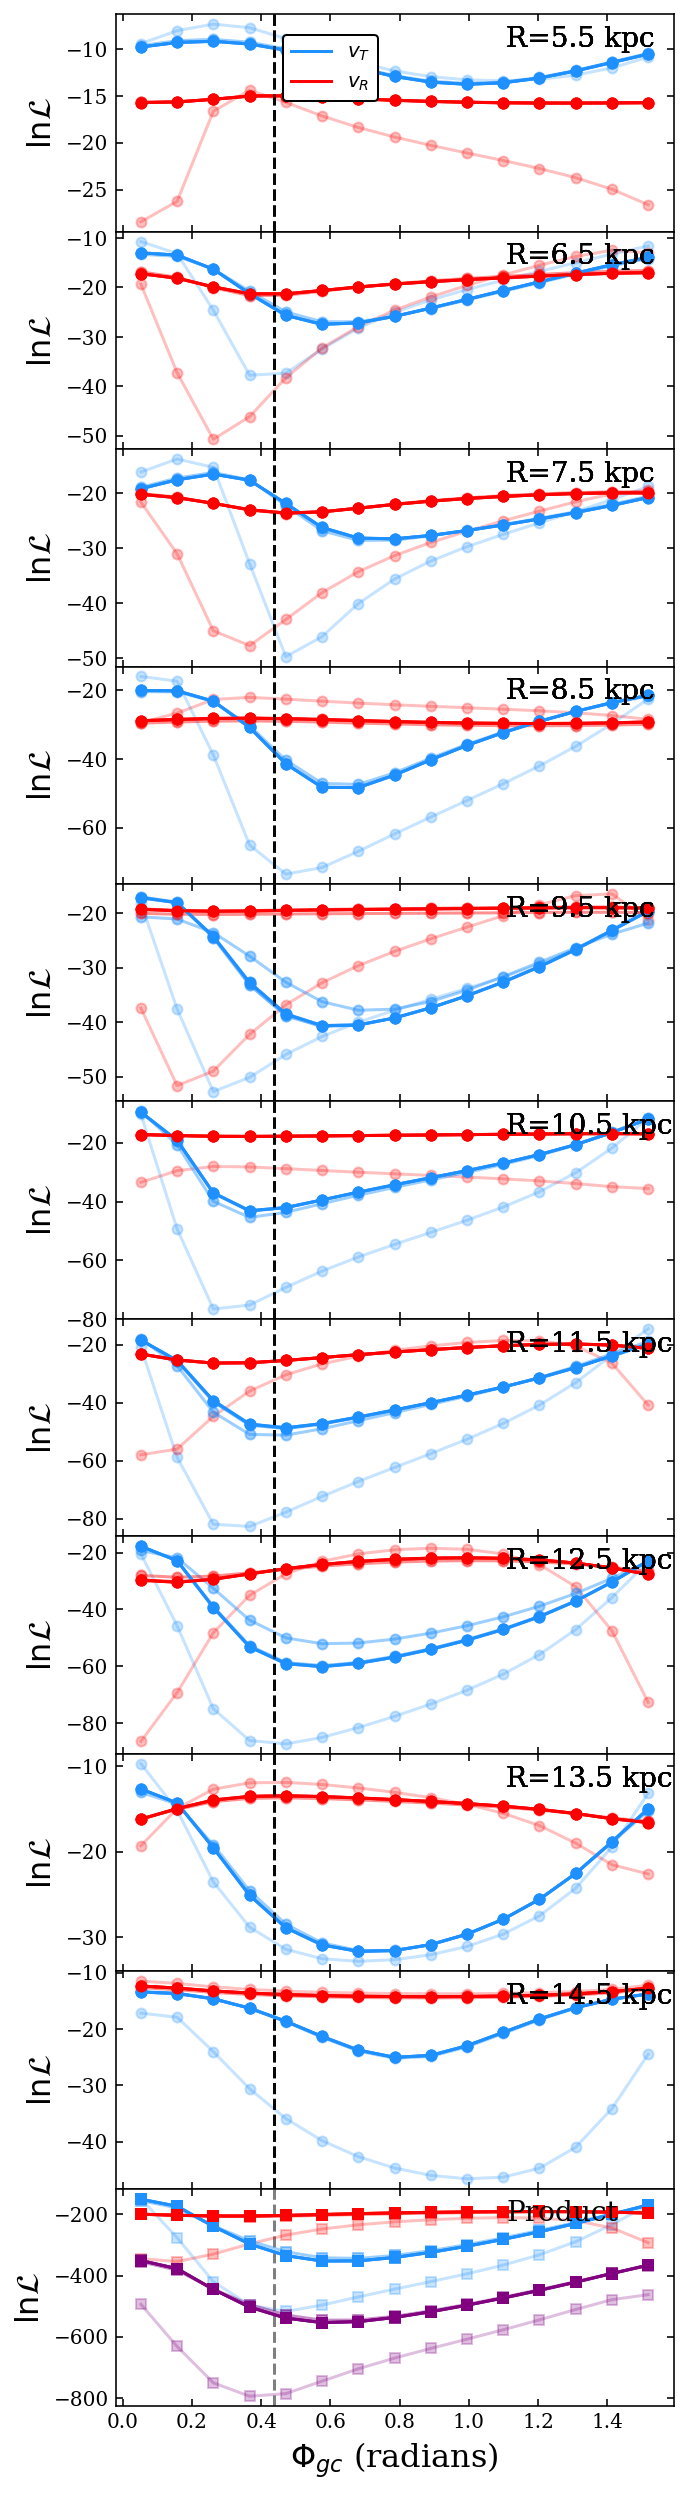

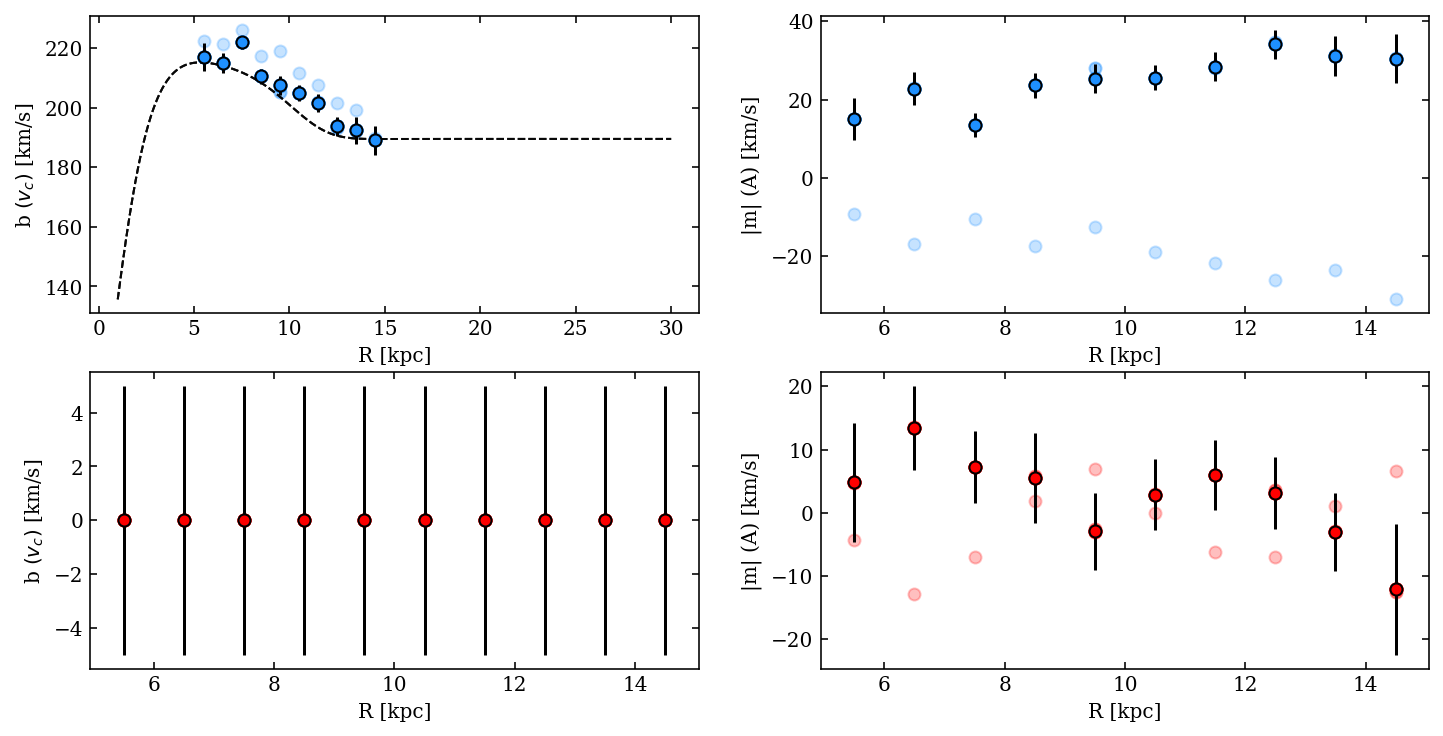

In [59]:
importlib.reload(ast1501.linear_model)

n_iterate = 5
var_arr = [25,np.inf,25,np.inf] # variance for b vT, m vT, b vR, m vR
force_yint_zero_vR = True

results, fig1, axs1, fig2, axs2 = ast1501.linear_model.run_iterating_linear_model(R_bin_cents, R_bin_size, 
                                                          phib_bin_cents, bs_samples_vT, 
                                                          bs_samples_vR, var_arr, 
                                                          force_yint_zero_vR, n_iterate, plot_results=True)
    
# Unpack interesting things
_, _, _, _, _, phib_data, bs_data, ms_data, bs_err_data, ms_err_data, _ = results[-1]
R_bin_cents_data = np.arange( R_lims[0], R_lims[1], R_bin_size ) + R_bin_size/2

plt.show()
plt.close('all')

In [49]:
fig = plt.figure( figsize=(12,6) ) 
axs = fig.subplots( nrows=2, ncols=2 )

axs[0,0].errorbar(R_bin_cents_data, bs_data[:,0], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_data[:,0], ecolor='Black', 
                  capsize=2, marker='o', label='5-15 kpc fit')

axs[0,1].errorbar(R_bin_cents_data, ms_data[:,0], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_data[:,0], ecolor='Black', 
                  capsize=2, marker='o')

axs[1,0].errorbar(R_bin_cents_data, bs_data[:,1], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_data[:,0], ecolor='Black', 
                  capsize=2, marker='o')

axs[1,1].errorbar(R_bin_cents_data, ms_data[:,1], fmt='o', markeredgecolor='Black', 
                  markerfacecolor='DodgerBlue', yerr=bs_err_data[:,0], ecolor='Black', 
                  capsize=2, marker='o')

prior_rs, prior_vts = np.load('../../data/generated/MWPotential2014_DF_vT_data.npy')
where_prior_in_rlims = np.where( (prior_rs < 15) & (prior_rs > 5) )[0]
axs[0,0].plot(prior_rs[where_prior_in_rlims], prior_vts[where_prior_in_rlims],
              linestyle='dotted', linewidth=1.0, color='Black', label='Prior')
axs[0,0].set_ylim(180,240)
axs[0,0].set_xlabel('R [kpc]')
axs[0,0].set_ylabel(r'b $(v_{c})$ [km/s]')
axs[0,1].set_xlabel('R [kpc]')
axs[0,1].set_ylabel(r'|m| (A) [km/s]')
axs[1,1].set_xlabel('R [kpc]')
axs[1,1].set_ylabel(r'|m| (A) [km/s]')
axs[1,0].set_xlabel('R [kpc]')
axs[1,0].set_ylabel(r'b $(v_{c})$ [km/s]')

Text(0,0.5,'b $(v_{c})$ [km/s]')

In [50]:
# Phib bin range and size
phib_lims = [0, np.pi/2]
phib_bin_size = np.pi/45
phib_bin_cents = np.arange( phib_lims[0], phib_lims[1], phib_bin_size ) + phi_bin_size/2

# Other
n_iterate = 3
var_arr = [25,np.inf,25,np.inf] # variance for b vT, m vT, b vR, m vR
force_yint_zero_vR = True

In [51]:
trihalo_file_base = '../8-radial_DF_generation/data/results_b'
trihalo_file_specs = ['90.npy','95.npy','98.npy','102.npy','105.npy','110.npy']
trihalo_files = [ trihalo_file_base+spec for spec in trihalo_file_specs ]

In [52]:
plot_colors = ['Navy','Red','DarkOrange','Purple','Green','Pink','Brown']
plot_labels = ['b=0.9','b=0.95','b=0.98','b=0.102','b=0.105','b=0.110']

for i in range( len(trihalo_files) ):
    
    R_bin_cents, results = ast1501.linear_model.fit_linear_model_df_data(trihalo_files[i], phib_bin_cents, var_arr, 
                                                            force_yint_zero_vR, n_iterate, force_phiB=0)
    _, _, _, _, _, phib, bs, ms, _, _, _ = results[-1]

    axs[0,0].plot(R_bin_cents, bs[:,0], color=plot_colors[i], label=plot_labels[i])
    axs[0,1].plot(R_bin_cents, ms[:,0], color=plot_colors[i])
    axs[1,0].plot(R_bin_cents, bs[:,1], color=plot_colors[i])
    axs[1,1].plot(R_bin_cents, ms[:,1], color=plot_colors[i])
###i


../../src/ast1501/linear_model.py:613: RuntimeWarning: divide by zero encountered in log
  store_likelihood_vT[j,:] = np.log(likelihood_vT)

../../src/ast1501/linear_model.py:620: RuntimeWarning: divide by zero encountered in log
  store_likelihood_vR[j,:] = np.log(likelihood_vR)



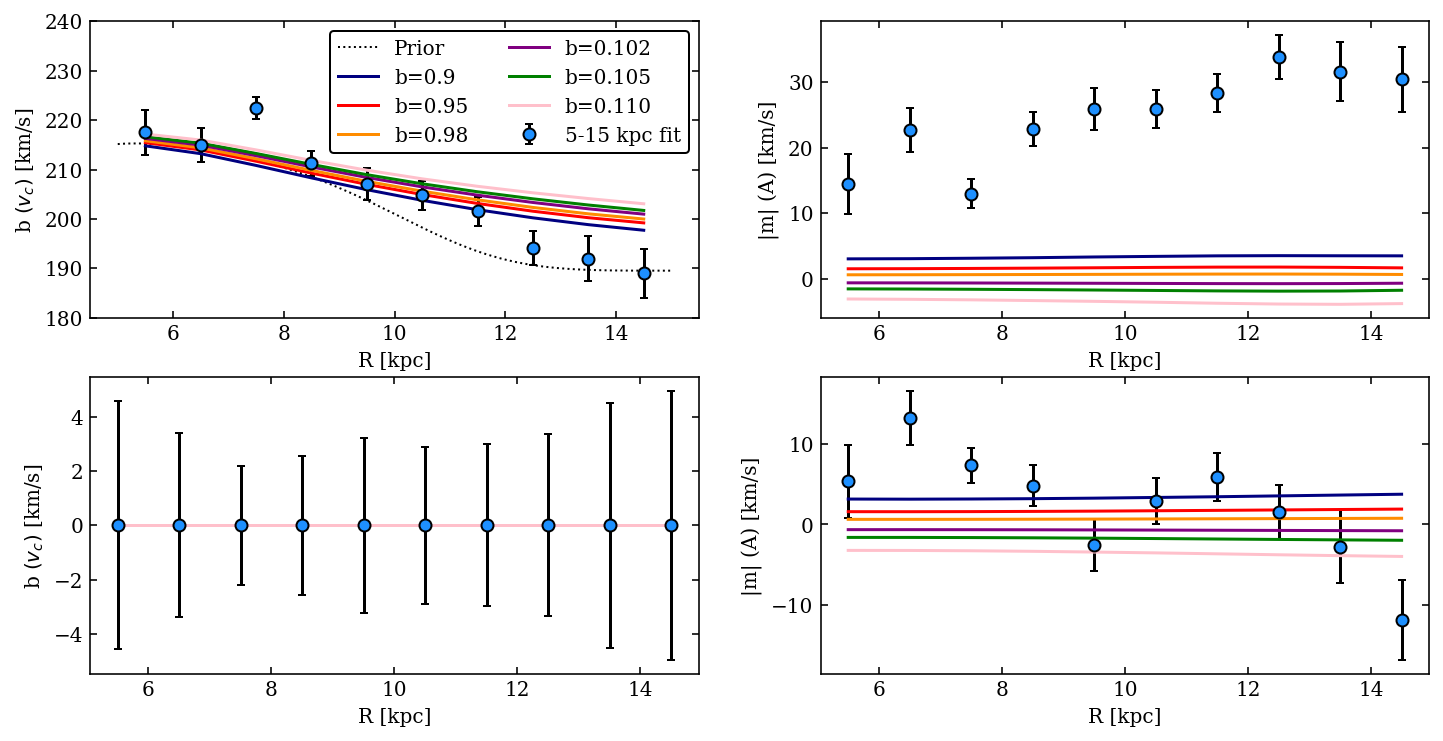

In [53]:
axs[0,0].legend(ncol=2)

fig.savefig('separate_radius_fits')
plt.show()
plt.clf()
plt.close('all')

pass;